# Claim2Features

## Util

In [1]:
from utils.ml_utils import myHotEncode, myHotDecode, plot_confusion_matrix, text_to_wordEmbedding
from utils.text_utils import treat_text, pure_words, words_count

### Ignore Warning

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Pre-processing

In [3]:
%%time
import pandas as pd
import ast
import numpy as np


data_path = 'dataset.csv'
df = pd.read_csv(data_path)

columns = ['tag', 'text', 'attrs', 'level', 'brother_tag', 'brother_text', 'brother_attrs', 'url', 'site', 'label']
ignore_site = ['politifact', 'checkyourfact', 'theferret', 'theconversation']
words_context = []
brother_words_context = []

none_texts = []

indexs = []
for i, d in enumerate(df.site):
    if d in ignore_site:
        indexs.append(i)
df = df.drop(indexs)
df = df.reset_index()

for tupla in df[columns].values:
    # In order to facilitate each instance is a dictionary 'dic'
    dic = {}
    for i, column in enumerate(columns):
        if column == 'text' or column == 'brother_text':
            dic[column] = str(tupla[i])
        else:
            dic[column] = tupla[i]
    
    # words_context attribute: the attrs is replace for words_context
    words_context_ = ''
    attrs = ast.literal_eval(dic['attrs'])
    for attr in attrs.values():
        if type(attr) == str:
            words_context_ += pure_words(treat_text(str(attr))) + ' '
        else:
            for a in attr:
                words_context_ += pure_words(treat_text(str(a))) + ' '
    words_context.append(words_context_)
    
    # brother_words_context attribute: : the brother_attrs is replace for brother_words_context
    brother_words_context_ = ''
    attrs = ast.literal_eval(dic['brother_attrs'])
    for attr in attrs.values():
        if type(attr) == str:
            brother_words_context_ += pure_words(treat_text(str(attr))) + ' '
        else:
            for a in attr:
                brother_words_context_ += pure_words(treat_text(str(a))) + ' '
    brother_words_context.append(brother_words_context_)
    

del df['attrs']
df['words_context'] = words_context

del df['brother_attrs']
df['brother_words_context'] = brother_words_context

Wall time: 8.08 s


## Features

### Bag-of-words for context words in attrs

In [4]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


vocab_size = 2000
vec = CountVectorizer(max_features=vocab_size, stop_words=ENGLISH_STOP_WORDS, tokenizer=LemmaTokenizer())
vec.fit(df['words_context'])
words_context = vec.transform(list(df['words_context'])).toarray()
brother_words_context = vec.transform(list(df['brother_words_context'])).toarray()

Wall time: 41.2 s


### Word2Vec for text

#### Load word2vec model

In [6]:
%%time
import gensim
from gensim.models import KeyedVectors

w2v_patch = 'C:\word_embedding\GoogleNews-vectors-negative300.bin'
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore", binary=True)

Wall time: 41.3 s


#### word2vec text feature

In [7]:
%%time
df['text_w2v'] = text_to_wordEmbedding(list(df['text']), w2v)
df['brother_text_w2v'] = text_to_wordEmbedding(list(df['brother_text']), w2v)
del w2v

Wall time: 35.7 s


### Text size

In [5]:
text_sizes = []
for size in df['text']:
    if type(size) == str:
        text_sizes.append([words_count(size)])
    else:
        text_sizes.append([0])
brother_text_sizes = []
for size in df['brother_text']:
    if type(size) == str:
        brother_text_sizes.append([words_count(size)])
    else:
        brother_text_sizes.append([0])

### Tag

In [8]:
tag2Idx = myHotEncode([df['tag']], 100)[1]
tag = myHotEncode([[x] for x in df['tag']], vocab2idx=tag2Idx)[0]
brother_tag = myHotEncode([[x] for x in df['brother_tag']], vocab2idx=tag2Idx)[0]

### Level

In [10]:
level = df['level']

## SVM

### Data preparation and test function

In [11]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


my_X = []
my_y = []

def features(features_list, tag, text_size, words_context, wordEmbedding, level,
             brother_tag, brother_text_size, brother_words_context, brother_wordEmbedding,
             parent_tag, parent_text_size, parent_words_context, parent_wordEmbedding):
    global my_X
    ret = []
    
    if 'tag' in features_list:
        ret += list(tag)
    
    if 'level' in features_list:
        ret += [level]
    
    if 'words_context' in features_list:
        ret += list(words_context)
    
    if 'wordEmbedding' in features_list:
        ret += list(wordEmbedding)
    
    if 'text_size' in features_list:
        ret += list(text_size)

    if 'brother_tag' in features_list:
        ret += list(brother_tag)
    
    if 'brother_text_size' in features_list:
        ret += list(brother_text_size)
    
    if 'brother_words_context' in features_list:
        ret += list(brother_words_context)
        
    if 'brother_wordEmbedding' in features_list:
        ret += list(brother_wordEmbedding)
    
    if 'parent_tag' in features_list:
        ret += list(parent_tag)
    
    if 'parent_text_size' in features_list:
        ret += list(parent_text_size)
    
    if 'parent_words_context' in features_list:
        ret += list(parent_words_context)
        
    if 'parent_wordEmbedding' in features_list:
        ret += list(parent_wordEmbedding)
    
    my_X_ = {
        'level': level,
        'text_size': text_size,
        'brother_text_size': brother_text_size,
        'parent_text_size': parent_text_size,
    }
    my_X.append(my_X_)
    return ret


def run_test(features_list):
    
    global my_y
    
    last_levels = [-1]
    last_labels = ['None']

    last_tags = []
    last_text_sizes = []
    last_words_contexts = []
    last_wordEmbedding = []
    last_brother_tags = []
    last_brother_text_sizes = []
    last_brother_words_contexts = []
    last_brother_wordEmbedding = []

    X = []
    X_ = []
    y = []
    group = []
    last_group = None
    last_url = 'NONE'

    sizes = set()

    for i in range(len(df)):
        if last_url != 'NONE' and df['url'][i] != last_url:
            if len(last_tags) > 0:
                # Parent
                if len(last_tags) > 1:
                    parent_tag = last_tags[-2]
                    parent_text_size = last_text_sizes[-2]
                    parent_words_context = last_words_contexts[-2]
                    parent_wordEmbedding = last_wordEmbedding[-2]
                else:
                    print("whattt???")
                    parent_tag = np.zeros(len(last_tags[-1]))
                    parent_text_size = np.zeros(len(last_text_sizes[-1]))
                    parent_words_contexts = np.zeros(len(last_words_contexts[-1]))
                    parent_wordEmbedding = np.zeros(len(last_wordEmbedding[-1]))
                x = features(features_list, last_tags[-1], last_text_sizes[-1], last_words_contexts[-1], last_wordEmbedding[-1], last_levels[-1], 
                             last_brother_tags[-1], last_brother_text_sizes[-1], last_brother_words_contexts[-1], last_brother_wordEmbedding[-1],
                             parent_tag, parent_text_size, parent_words_context, parent_wordEmbedding)
                X.append(x)
                X_.append(list(last_tags[-1]).index(1)) # Debug control
                sizes.add(len(x))
                y_ = 'None'
                for y__ in last_labels:
                    if y__ != 'None':
                        y_ = y__
                y.append(y_)
                group.append(last_group)
                last_labels = ['None']
                last_tags = []
                last_text_sizes = []
                last_words_contexts = []
                last_wordEmbedding = []
                last_levels = [-1]
                last_brother_tags = []
                last_brother_text_sizes = []
                last_brother_words_contexts = []
                last_brother_wordEmbedding = []
            last_url = df['url'][i]
            continue

        last_url = df['url'][i]
        level_ = df['level'][i]

        if level_ > last_levels[-1]:
            last_tags.append(tag[i])
            last_text_sizes.append(text_sizes[i])
            last_words_contexts.append(words_context[i])
            last_wordEmbedding.append(df['text_w2v'][i])
            last_levels.append(level_)
            last_brother_tags.append(brother_tag[i])
            last_brother_text_sizes.append(brother_text_sizes[i])
            last_brother_words_contexts.append(brother_words_context[i])
            last_brother_wordEmbedding.append(df['brother_text_w2v'][i])
            last_labels.append(df['label'][i])

        else:
            if len(last_tags) > 0:
                # Parent
                if len(last_tags) > 1:
                    parent_tag = last_tags[-2]
                    parent_text_size = last_text_sizes[-2]
                    parent_words_context = last_words_contexts[-2]
                    parent_wordEmbedding = last_wordEmbedding[-2]
                else:
                    print("whatt???")
                    parent_tag = np.zeros(len(last_tags[-1]))
                    parent_text_size = np.zeros(len(last_text_sizes[-1]))
                    parent_words_contexts = np.zeros(len(last_words_contexts[-1]))
                    parent_wordEmbedding = np.zeros(len(last_wordEmbedding[-1]))
                x = features(features_list, last_tags[-1], last_text_sizes[-1], last_words_contexts[-1], last_wordEmbedding[-1], last_levels[-1], 
                             last_brother_tags[-1], last_brother_text_sizes[-1], last_brother_words_contexts[-1], last_brother_wordEmbedding[-1],
                             parent_tag, parent_text_size, parent_words_context, parent_wordEmbedding)
                X.append(x)
                X_.append(list(last_tags[-1]).index(1))  # Debug control
                sizes.add(len(x))
                y_ = 'None'
                for y__ in last_labels:
                    if y__ != 'None':
                        y_ = y__
                y.append(y_)
                group.append(last_group)
                # Remove last data used
                last_labels = last_labels[:level_-1]
                last_tags = last_tags[:level_-1]
                last_text_sizes = last_text_sizes[:level_-1]
                last_words_contexts = last_words_contexts[:level_-1]
                last_wordEmbedding = last_wordEmbedding[:level_-1]
                last_levels = last_levels[:level_-1]
                last_brother_tags = last_brother_tags[:level_-1]
                last_brother_text_sizes = last_brother_text_sizes[:level_-1]
                last_brother_words_contexts = last_brother_words_contexts[:level_-1]
                last_brother_wordEmbedding = last_brother_wordEmbedding[:level_-1]

                last_tags.append(tag[i])
                last_text_sizes.append(text_sizes[i])
                last_words_contexts.append(words_context[i])
                last_wordEmbedding.append(df['text_w2v'][i])
                last_levels.append(level_)
                last_brother_tags.append(brother_tag[i])
                last_brother_text_sizes.append(brother_text_sizes[i])
                last_brother_words_contexts.append(brother_words_context[i])
                last_brother_wordEmbedding.append(df['brother_text_w2v'][i])
                last_labels.append(df['label'][i])
        last_group = df['site'][i]

    if len(last_tags) > 0:
        # Parent
        if len(last_tags) > 1:
            parent_tag = last_tags[-2]
            parent_text_size = last_text_sizes[-2]
            parent_words_context = last_words_contexts[-2]
            parent_wordEmbedding = last_wordEmbedding[-2]
        else:
            print("what???")
            parent_tag = np.zeros(len(last_tags[-1]))
            parent_text_size = np.zeros(len(last_text_sizes[-1]))
            parent_words_contexts = np.zeros(len(last_words_contexts[-1]))
            parent_wordEmbedding = np.zeros(len(last_wordEmbedding[-1]))
        x = features(features_list, last_tags[-1], last_text_sizes[-1], last_words_contexts[-1], last_wordEmbedding[-1], last_levels[-1], 
                     last_brother_tags[-1], last_brother_text_sizes[-1], last_brother_words_contexts[-1], last_brother_wordEmbedding[-1],
                     parent_tag, parent_text_size, parent_words_context, parent_wordEmbedding)
        X.append(x)
        X_.append(list(last_tags[-1]).index(1)) # Debug control
        sizes.add(len(x))
        y_ = 'None'
        for y__ in last_labels:
            if y__ != 'None':
                y_ = y__
        y.append(y_)
        group.append(last_group)

    X = np.array(X)
    y = np.array(y)
    my_y = y
    group = np.array(group)
    

    accuracy = []
    precision = []
    recall = []
    f1 = []
    confusion = []

    # Aux print
    _, site2Idx = myHotEncode([[u] for u in group])

    gp = GroupKFold(n_splits=7)
    for train_indexs, test_indexs in gp.split(X, groups=group):

        X_train = X[train_indexs]
        y_train = y[train_indexs]

        X_test = X[test_indexs]
        y_test = y[test_indexs]

        groups_train = group[train_indexs]
        groups_test = group[test_indexs]
        train_g = set()
        test_g = set()
        for g in groups_train:
            train_g.add(site2Idx[g])
        for g in groups_test:
            test_g.add(site2Idx[g])
        print('Train Groups (URLs)', train_g)
        print('Test Groups (URLs)', test_g)

        svm = LinearSVC()
        svm.fit(X_train, y_train)
        result = svm.predict(X_test)

        acc = accuracy_score(result, y_test)
        accuracy.append(acc)
        p = precision_score(result, y_test, average="macro")
        precision.append(p)
        r = recall_score(result, y_test, average="macro")
        recall.append(r)
        f = f1_score(result, y_test, average="macro")
        f1.append(f)
        cm_ = confusion_matrix(result, y_test)
        plot_confusion_matrix(cm_, svm.classes_, normalize=True) 
        confusion.append(cm_)

        print("%s: %.2f %%" % ('Acc', acc*100))
        print("%s: %.2f %%" % ('Precision', p*100))
        print("%s: %.2f %%" % ('Recall', r*100))
        print("%s: %.2f %%" % ('F1', f*100))
        print('')

    print("Acc %.2f %% (+/- %.2f %%)" % (np.mean(accuracy)*100, np.std(accuracy)*100))
    print("Precision %.2f %% (+/- %.2f %%)" % (np.mean(precision)*100, np.std(precision)*100))
    print("Recall %.2f %% (+/- %.2f %%)" % (np.mean(recall)*100, np.std(recall)*100))
    print("F1 %.2f %% (+/- %.2f %%)" % (np.mean(f1)*100, np.std(f1)*100))

    nc = []
    for c in confusion:
        d = len(svm.classes_) - len(c)
        c = np.pad(c, (0,d), 'constant')
        nc.append(c)
    confusion = nc
    cm = np.mean(confusion, axis=0)
    plot_confusion_matrix(cm, svm.classes_, normalize=True)

Using TensorFlow backend.


# RESULTS

In [ ]:
F1     Feature
38.40  tag
19.42  text_size
23.48  words_context
26.05  wordEmbedding
19.42  level
20.91  brother_tag
19.60  brother_text_size
24.05  brother_words_context
26.73  brother_wordEmbedding
22.06  parent_tag
19.40  parent_text_size
21.35  parent_words_context
26.67  parent_wordEmbedding
39.46  selected features

### Tag

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


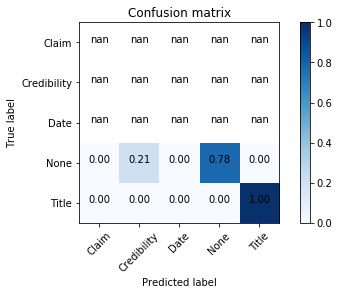

Acc: 78.09 %
Precision: 40.00 %
Recall: 35.60 %
F1: 37.53 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


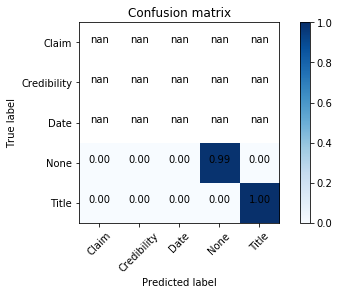

Acc: 98.64 %
Precision: 30.00 %
Recall: 39.73 %
F1: 33.20 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


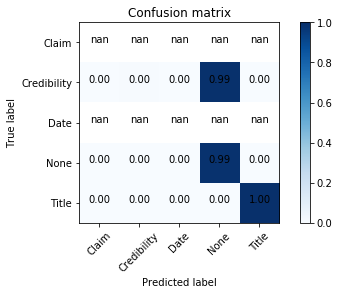

Acc: 93.46 %
Precision: 40.82 %
Recall: 39.93 %
F1: 39.49 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


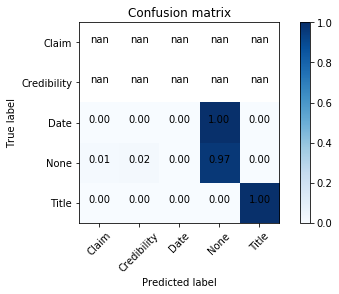

Acc: 95.64 %
Precision: 39.77 %
Recall: 39.34 %
F1: 39.55 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


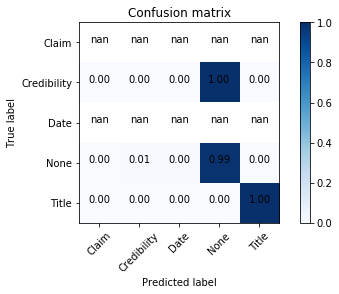

Acc: 97.18 %
Precision: 39.72 %
Recall: 39.71 %
F1: 39.71 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


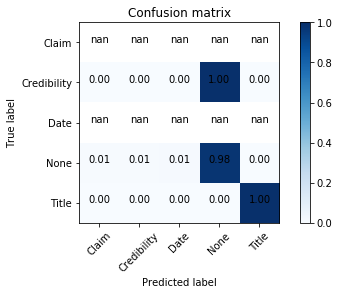

Acc: 95.53 %
Precision: 39.48 %
Recall: 39.60 %
F1: 39.54 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


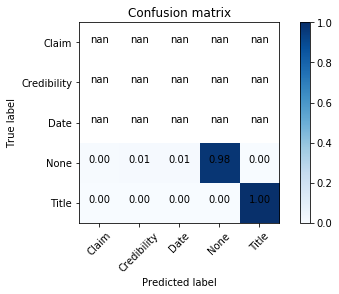

Acc: 97.64 %
Precision: 40.00 %
Recall: 39.52 %
F1: 39.76 %

Acc 93.74 % (+/- 6.58 %)
Precision 38.54 % (+/- 3.51 %)
Recall 39.06 % (+/- 1.42 %)
F1 38.40 % (+/- 2.24 %)


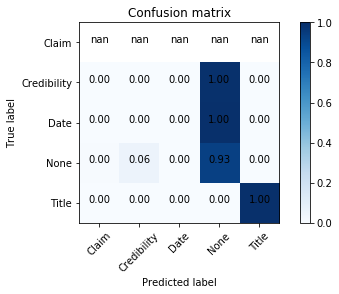

Wall time: 14.2 s


In [13]:
%%time
run_test(['tag'])

### Text Size

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


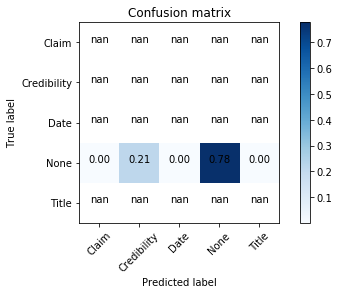

Acc: 77.75 %
Precision: 20.00 %
Recall: 15.55 %
F1: 17.50 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


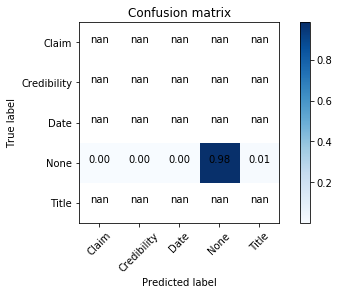

Acc: 98.25 %
Precision: 20.00 %
Recall: 19.65 %
F1: 19.82 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


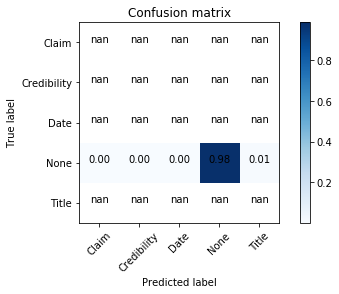

Acc: 98.47 %
Precision: 20.00 %
Recall: 19.69 %
F1: 19.85 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


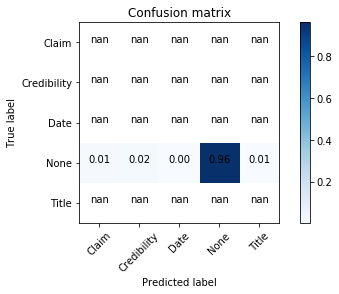

Acc: 96.10 %
Precision: 20.00 %
Recall: 19.22 %
F1: 19.60 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


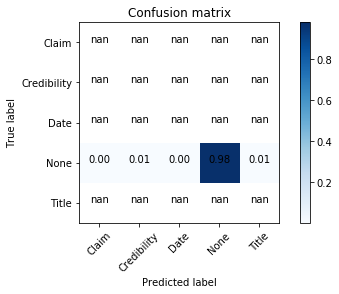

Acc: 97.86 %
Precision: 20.00 %
Recall: 19.57 %
F1: 19.78 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


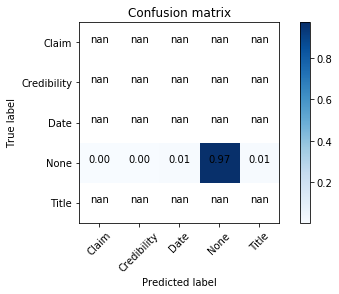

Acc: 97.08 %
Precision: 20.00 %
Recall: 19.42 %
F1: 19.70 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


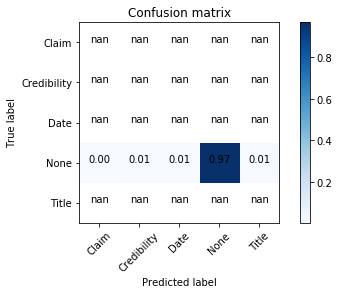

Acc: 96.66 %
Precision: 20.00 %
Recall: 19.33 %
F1: 19.66 %

Acc 94.60 % (+/- 6.93 %)
Precision 20.00 % (+/- 0.00 %)
Recall 18.92 % (+/- 1.39 %)
F1 19.42 % (+/- 0.79 %)


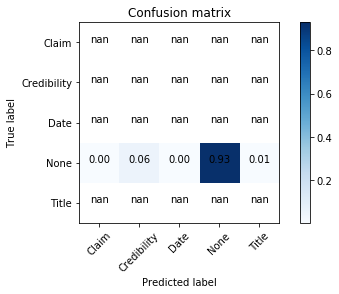

Wall time: 1min 24s


In [12]:
%%time
run_test(['text_size'])

### Words Context

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


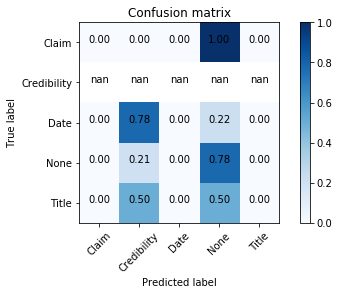

Acc: 77.38 %
Precision: 19.91 %
Recall: 15.67 %
F1: 17.53 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


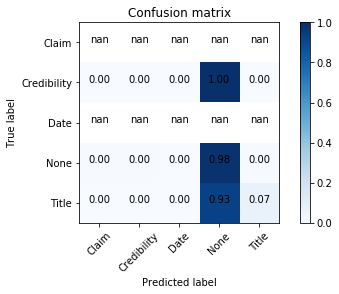

Acc: 86.74 %
Precision: 27.58 %
Recall: 21.02 %
F1: 20.93 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


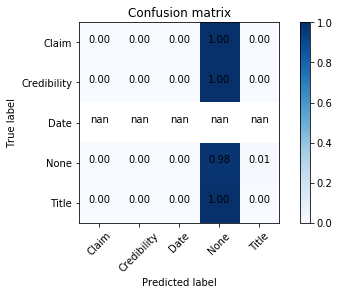

Acc: 91.85 %
Precision: 18.65 %
Recall: 19.67 %
F1: 19.15 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


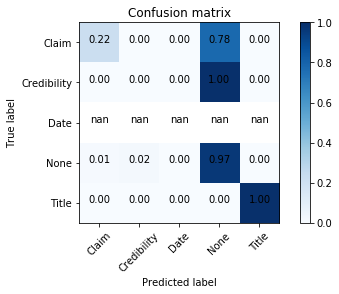

Acc: 94.13 %
Precision: 34.39 %
Recall: 43.75 %
F1: 37.39 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


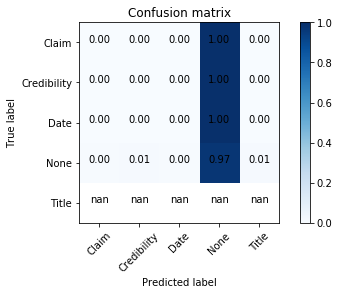

Acc: 81.50 %
Precision: 16.66 %
Recall: 19.50 %
F1: 17.97 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


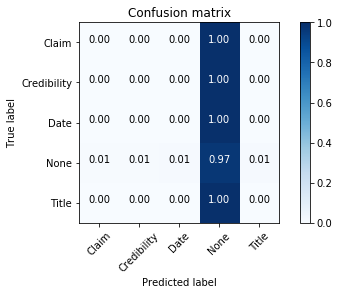

Acc: 93.24 %
Precision: 19.21 %
Recall: 19.39 %
F1: 19.30 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


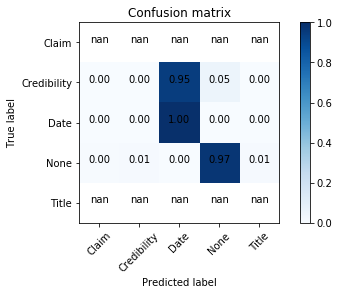

Acc: 97.05 %
Precision: 28.94 %
Recall: 39.50 %
F1: 32.11 %

Acc 88.84 % (+/- 6.69 %)
Precision 23.62 % (+/- 6.17 %)
Recall 25.50 % (+/- 10.37 %)
F1 23.48 % (+/- 7.33 %)


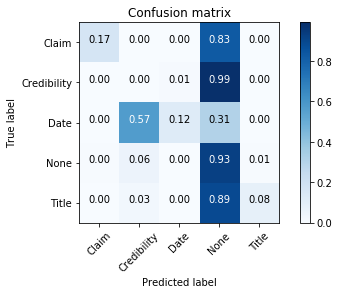

Wall time: 1min 3s


In [13]:
%%time
run_test(['words_context'])

### Word Embedding

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


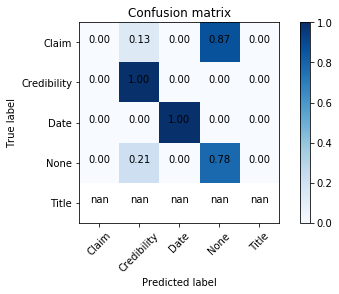

Acc: 77.94 %
Precision: 40.14 %
Recall: 55.60 %
F1: 37.88 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


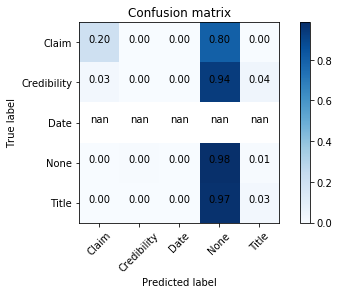

Acc: 95.80 %
Precision: 20.74 %
Recall: 24.21 %
F1: 21.09 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


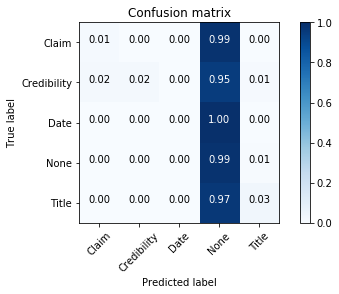

Acc: 94.21 %
Precision: 25.35 %
Recall: 21.10 %
F1: 21.13 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


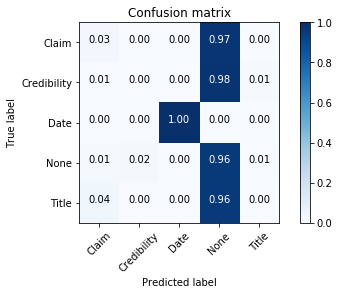

Acc: 92.71 %
Precision: 21.54 %
Recall: 39.76 %
F1: 23.24 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


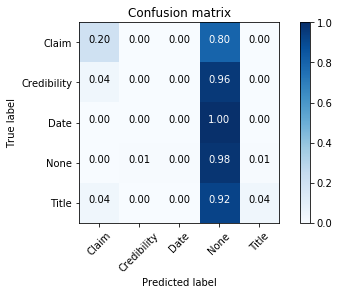

Acc: 96.62 %
Precision: 21.24 %
Recall: 24.35 %
F1: 21.87 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


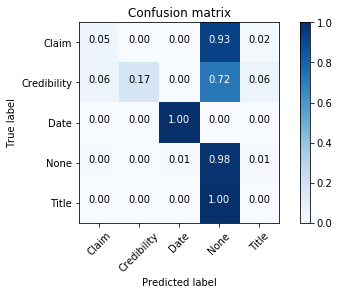

Acc: 95.96 %
Precision: 34.66 %
Recall: 43.78 %
F1: 35.50 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


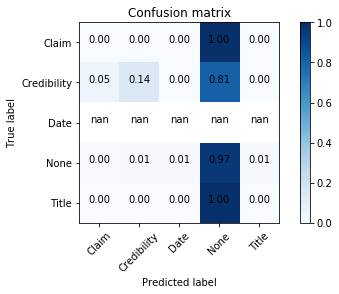

Acc: 96.27 %
Precision: 21.44 %
Recall: 22.21 %
F1: 21.62 %

Acc 92.79 % (+/- 6.19 %)
Precision 26.45 % (+/- 7.22 %)
Recall 33.00 % (+/- 12.44 %)
F1 26.05 % (+/- 6.79 %)


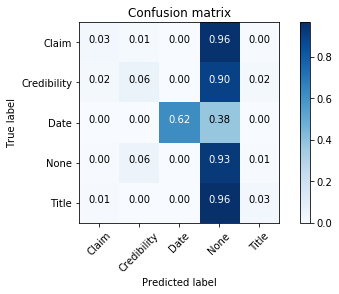

Wall time: 11min 24s


In [14]:
%%time
run_test(['wordEmbedding'])

### Level

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


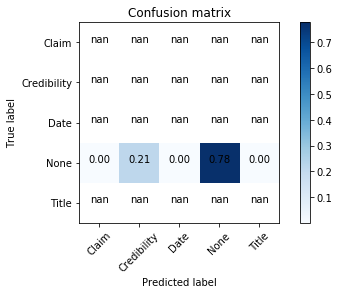

Acc: 77.75 %
Precision: 20.00 %
Recall: 15.55 %
F1: 17.50 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


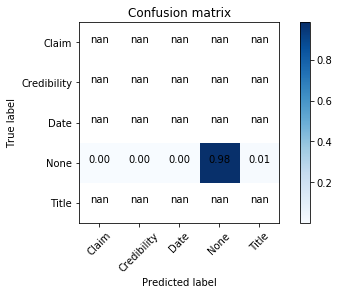

Acc: 98.25 %
Precision: 20.00 %
Recall: 19.65 %
F1: 19.82 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


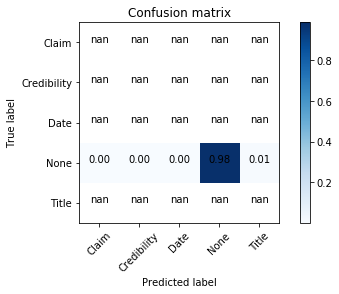

Acc: 98.47 %
Precision: 20.00 %
Recall: 19.69 %
F1: 19.85 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


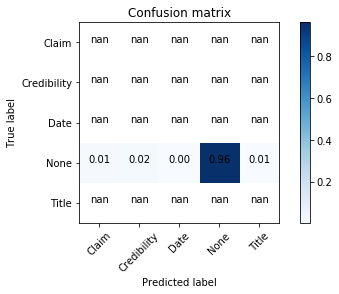

Acc: 96.10 %
Precision: 20.00 %
Recall: 19.22 %
F1: 19.60 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


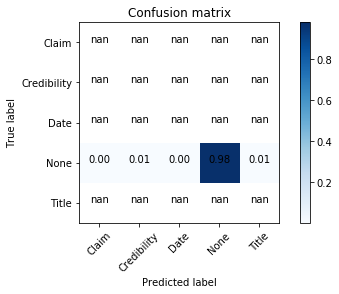

Acc: 97.86 %
Precision: 20.00 %
Recall: 19.57 %
F1: 19.78 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


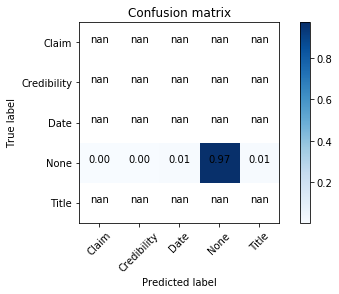

Acc: 97.08 %
Precision: 20.00 %
Recall: 19.42 %
F1: 19.70 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


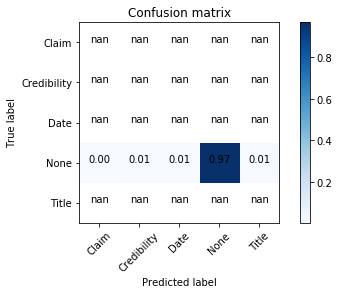

Acc: 96.66 %
Precision: 20.00 %
Recall: 19.33 %
F1: 19.66 %

Acc 94.60 % (+/- 6.93 %)
Precision 20.00 % (+/- 0.00 %)
Recall 18.92 % (+/- 1.39 %)
F1 19.42 % (+/- 0.79 %)


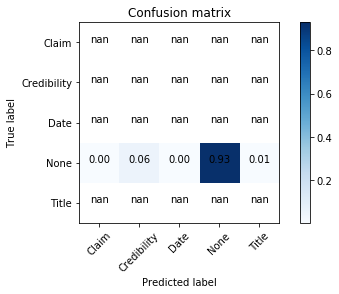

Wall time: 1min 23s


In [15]:
%%time
run_test(['level'])

### Brother_Tag

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


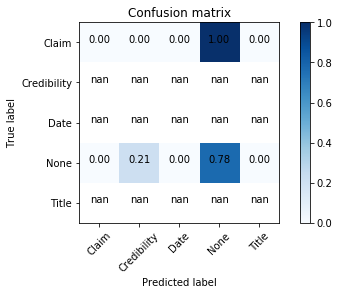

Acc: 77.58 %
Precision: 19.96 %
Recall: 15.54 %
F1: 17.47 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


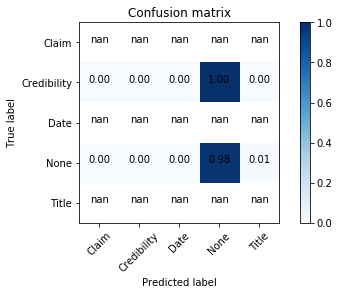

Acc: 98.11 %
Precision: 19.97 %
Recall: 19.65 %
F1: 19.81 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


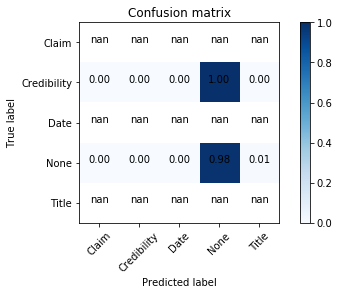

Acc: 96.97 %
Precision: 19.69 %
Recall: 19.69 %
F1: 19.69 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


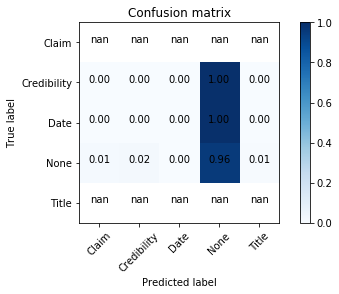

Acc: 95.36 %
Precision: 19.85 %
Recall: 19.21 %
F1: 19.53 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


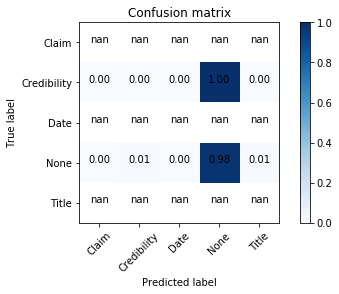

Acc: 96.71 %
Precision: 19.76 %
Recall: 19.57 %
F1: 19.67 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


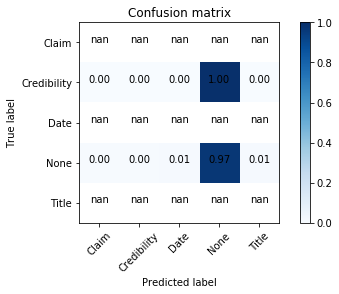

Acc: 96.48 %
Precision: 19.87 %
Recall: 19.41 %
F1: 19.64 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


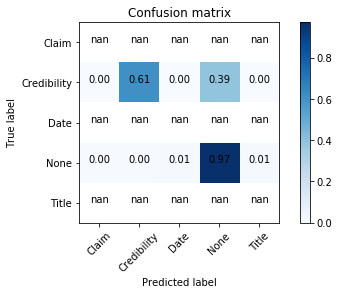

Acc: 96.83 %
Precision: 29.68 %
Recall: 31.68 %
F1: 30.53 %

Acc 94.00 % (+/- 6.75 %)
Precision 21.26 % (+/- 3.44 %)
Recall 20.68 % (+/- 4.70 %)
F1 20.91 % (+/- 4.00 %)


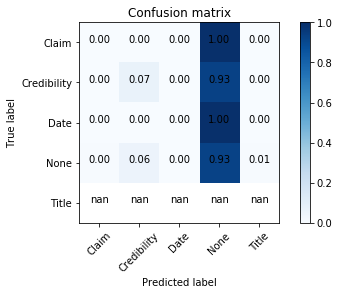

Wall time: 16.4 s


In [16]:
%%time
run_test(['brother_tag'])

### Brother Text Size

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


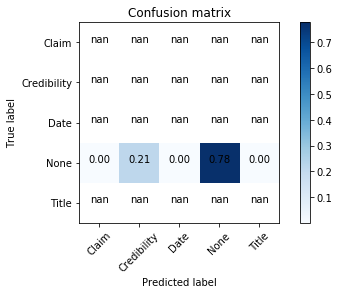

Acc: 77.75 %
Precision: 20.00 %
Recall: 15.55 %
F1: 17.50 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


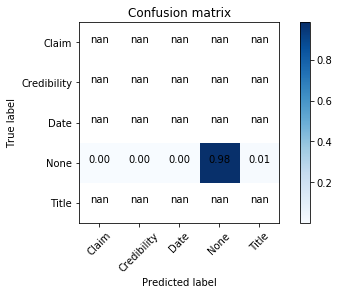

Acc: 98.25 %
Precision: 20.00 %
Recall: 19.65 %
F1: 19.82 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


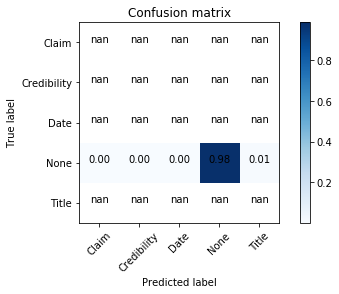

Acc: 98.47 %
Precision: 20.00 %
Recall: 19.69 %
F1: 19.85 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


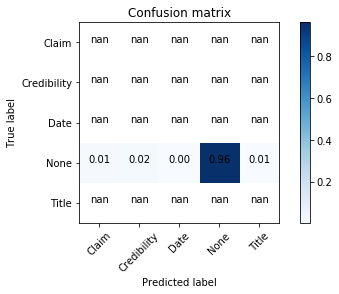

Acc: 96.10 %
Precision: 20.00 %
Recall: 19.22 %
F1: 19.60 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


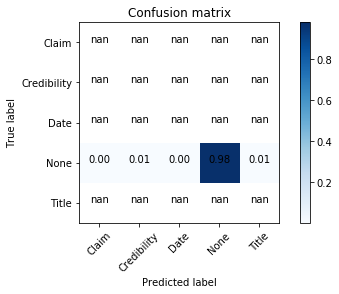

Acc: 97.86 %
Precision: 20.00 %
Recall: 19.57 %
F1: 19.78 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


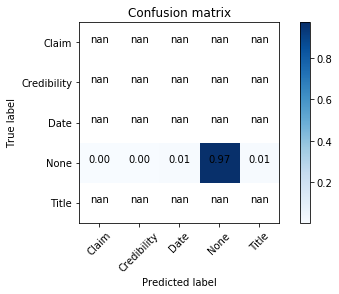

Acc: 97.08 %
Precision: 20.00 %
Recall: 19.42 %
F1: 19.70 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


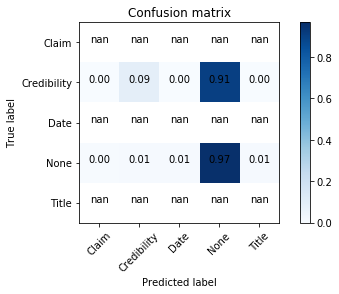

Acc: 96.23 %
Precision: 20.92 %
Recall: 21.16 %
F1: 20.93 %

Acc 94.53 % (+/- 6.91 %)
Precision 20.13 % (+/- 0.32 %)
Recall 19.18 % (+/- 1.59 %)
F1 19.60 % (+/- 0.95 %)


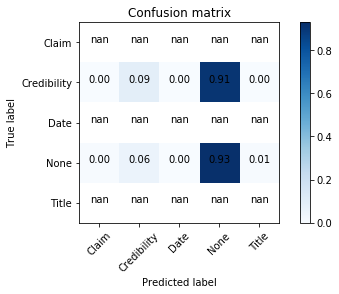

Wall time: 1min 28s


In [17]:
%%time
run_test(['brother_text_size'])

### Brother Words Context

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


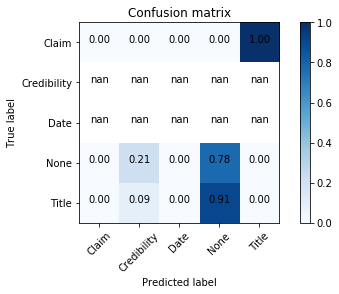

Acc: 77.58 %
Precision: 19.96 %
Recall: 15.55 %
F1: 17.48 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


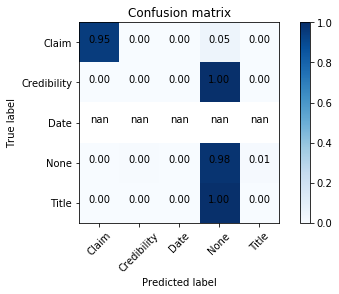

Acc: 97.41 %
Precision: 29.79 %
Recall: 38.73 %
F1: 32.85 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


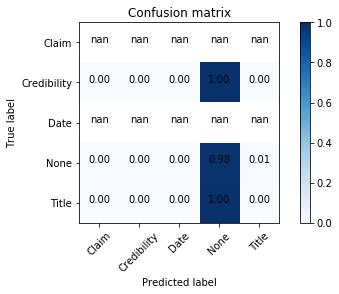

Acc: 97.51 %
Precision: 19.81 %
Recall: 19.69 %
F1: 19.75 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


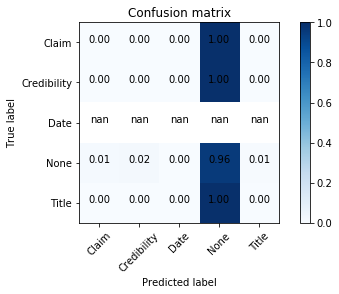

Acc: 94.94 %
Precision: 19.76 %
Recall: 19.21 %
F1: 19.48 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


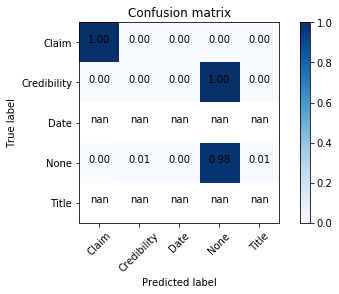

Acc: 94.83 %
Precision: 39.31 %
Recall: 39.63 %
F1: 39.47 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


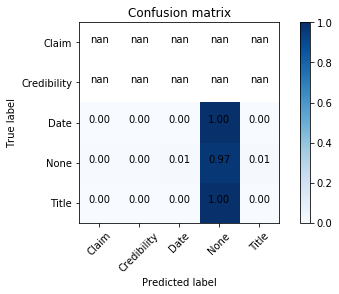

Acc: 96.91 %
Precision: 19.96 %
Recall: 19.42 %
F1: 19.69 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


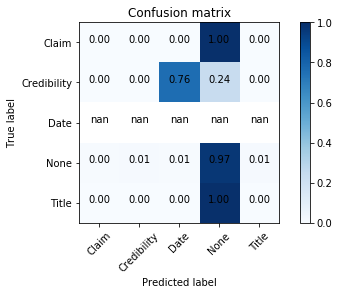

Acc: 96.03 %
Precision: 19.87 %
Recall: 19.40 %
F1: 19.63 %

Acc 93.60 % (+/- 6.62 %)
Precision 24.06 % (+/- 7.10 %)
Recall 24.52 % (+/- 9.37 %)
F1 24.05 % (+/- 7.89 %)


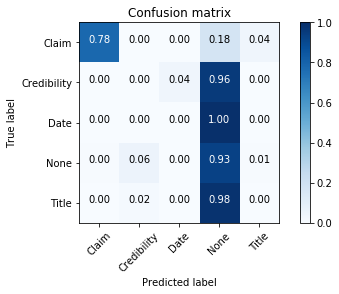

Wall time: 1min 10s


In [18]:
%%time
run_test(['brother_words_context'])

### Brother Word Embedding

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


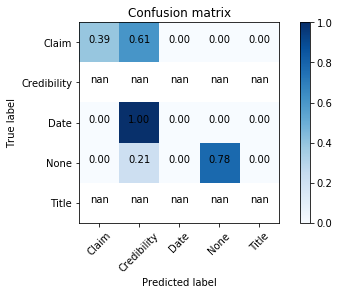

Acc: 77.86 %
Precision: 26.19 %
Recall: 23.47 %
F1: 24.46 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


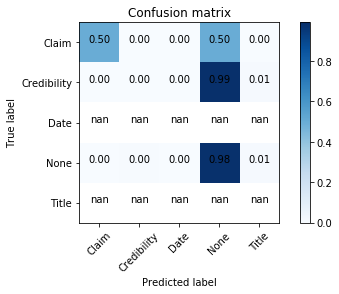

Acc: 94.80 %
Precision: 29.26 %
Recall: 29.68 %
F1: 29.47 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


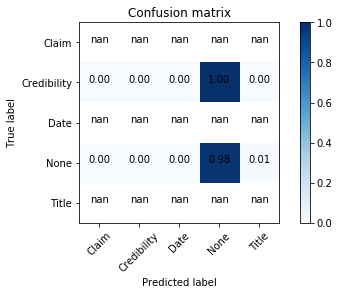

Acc: 95.62 %
Precision: 19.42 %
Recall: 19.69 %
F1: 19.55 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


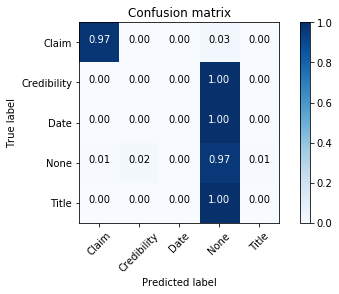

Acc: 94.56 %
Precision: 29.42 %
Recall: 38.81 %
F1: 32.54 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


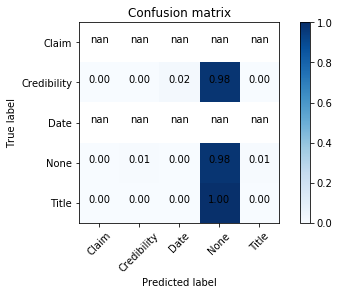

Acc: 96.11 %
Precision: 19.64 %
Recall: 19.57 %
F1: 19.61 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


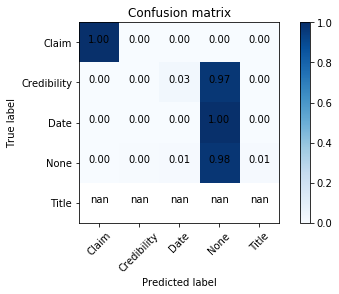

Acc: 95.96 %
Precision: 39.67 %
Recall: 39.51 %
F1: 39.59 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


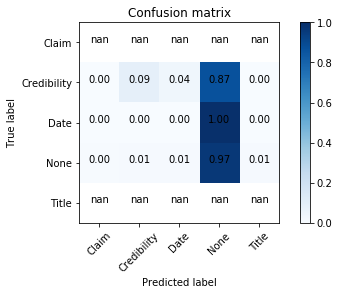

Acc: 95.13 %
Precision: 23.24 %
Recall: 21.14 %
F1: 21.88 %

Acc 92.86 % (+/- 6.15 %)
Precision 26.69 % (+/- 6.52 %)
Recall 27.41 % (+/- 8.09 %)
F1 26.73 % (+/- 6.94 %)


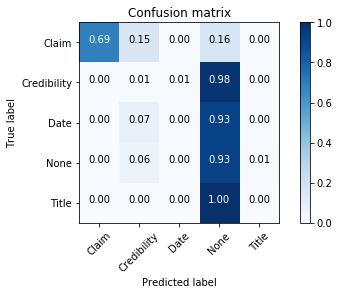

Wall time: 15min 20s


In [19]:
%%time
run_test(['brother_wordEmbedding'])

### Parent Tag

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


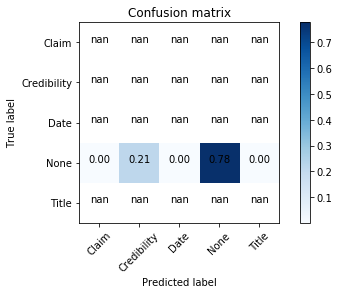

Acc: 77.75 %
Precision: 20.00 %
Recall: 15.55 %
F1: 17.50 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


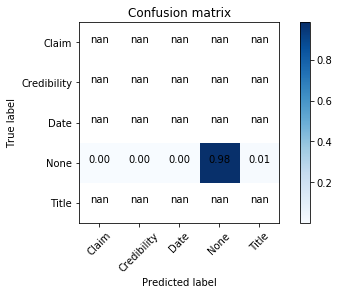

Acc: 98.25 %
Precision: 20.00 %
Recall: 19.65 %
F1: 19.82 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


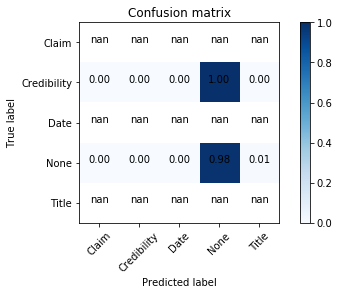

Acc: 98.37 %
Precision: 19.98 %
Recall: 19.69 %
F1: 19.84 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


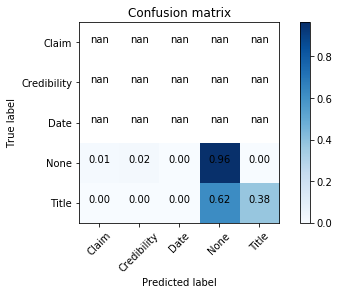

Acc: 95.88 %
Precision: 29.89 %
Recall: 26.83 %
F1: 28.18 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


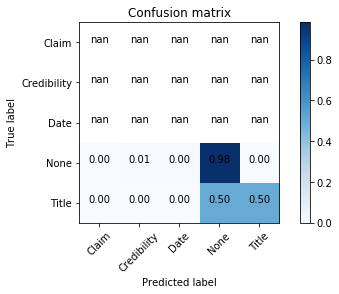

Acc: 97.86 %
Precision: 29.93 %
Recall: 29.64 %
F1: 29.78 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


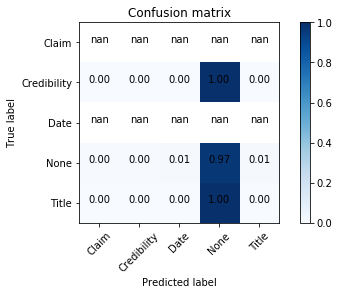

Acc: 96.55 %
Precision: 19.89 %
Recall: 19.41 %
F1: 19.65 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


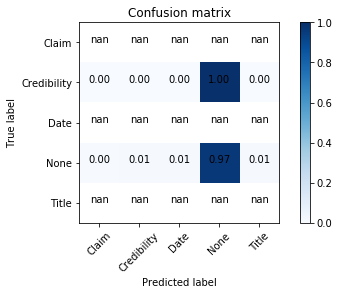

Acc: 96.52 %
Precision: 19.97 %
Recall: 19.33 %
F1: 19.65 %

Acc 94.45 % (+/- 6.88 %)
Precision 22.81 % (+/- 4.49 %)
Recall 21.44 % (+/- 4.56 %)
F1 22.06 % (+/- 4.46 %)


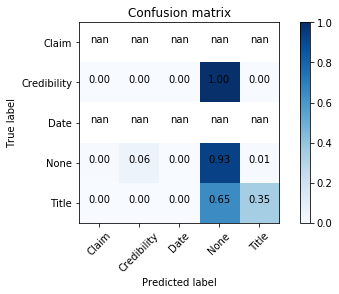

Wall time: 14.5 s


In [20]:
%%time
run_test(['parent_tag'])

### Parent Text Size

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


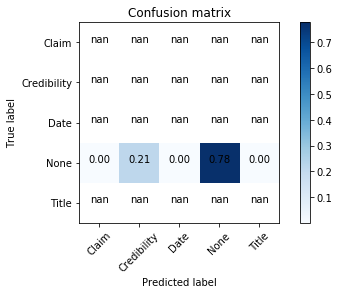

Acc: 77.75 %
Precision: 20.00 %
Recall: 15.55 %
F1: 17.50 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


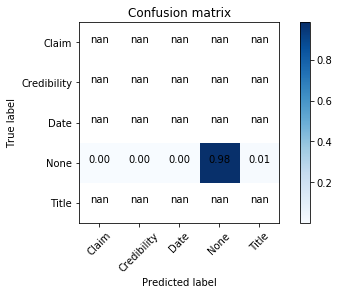

Acc: 98.25 %
Precision: 20.00 %
Recall: 19.65 %
F1: 19.82 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


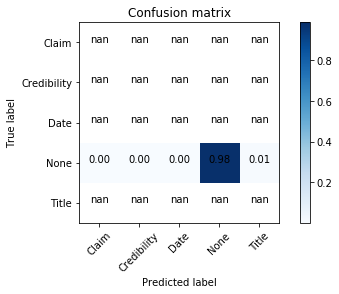

Acc: 98.47 %
Precision: 20.00 %
Recall: 19.69 %
F1: 19.85 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


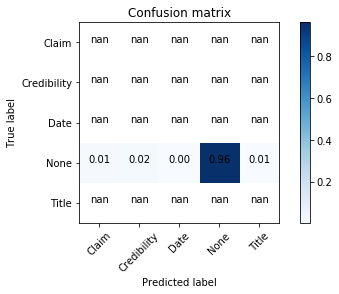

Acc: 96.10 %
Precision: 20.00 %
Recall: 19.22 %
F1: 19.60 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


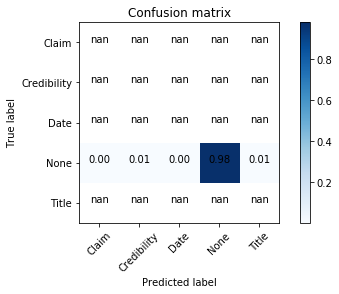

Acc: 97.86 %
Precision: 20.00 %
Recall: 19.57 %
F1: 19.78 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


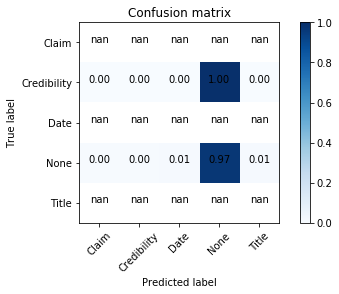

Acc: 95.65 %
Precision: 19.70 %
Recall: 19.41 %
F1: 19.56 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


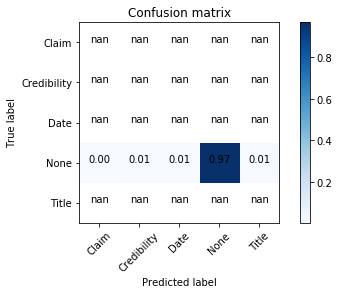

Acc: 96.66 %
Precision: 20.00 %
Recall: 19.33 %
F1: 19.66 %

Acc 94.39 % (+/- 6.87 %)
Precision 19.96 % (+/- 0.10 %)
Recall 18.92 % (+/- 1.38 %)
F1 19.40 % (+/- 0.78 %)


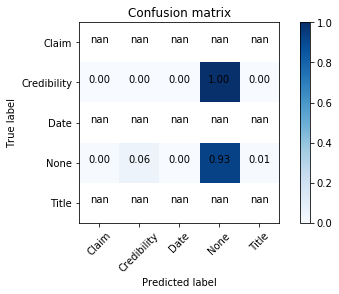

Wall time: 1min 16s


In [21]:
%%time
run_test(['parent_text_size'])

### Parent Words Context

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


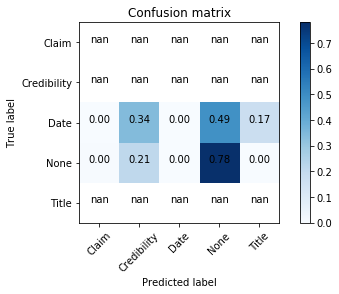

Acc: 77.41 %
Precision: 19.91 %
Recall: 15.59 %
F1: 17.49 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


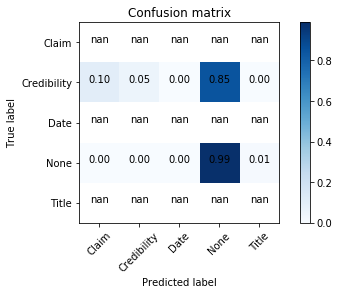

Acc: 95.17 %
Precision: 29.33 %
Recall: 20.76 %
F1: 21.37 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


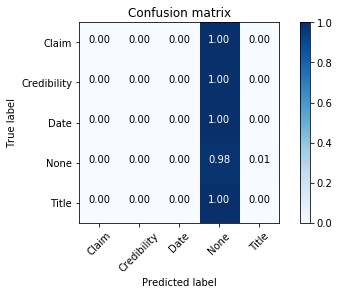

Acc: 96.96 %
Precision: 19.69 %
Recall: 19.69 %
F1: 19.69 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


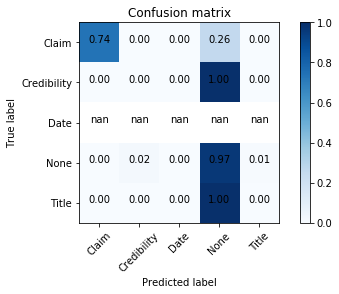

Acc: 89.60 %
Precision: 33.26 %
Recall: 34.16 %
F1: 33.70 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


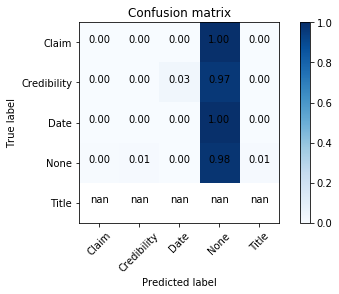

Acc: 87.44 %
Precision: 17.87 %
Recall: 19.60 %
F1: 18.69 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


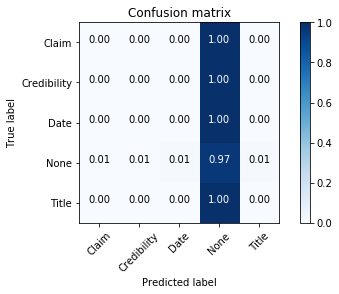

Acc: 89.69 %
Precision: 18.48 %
Recall: 19.37 %
F1: 18.91 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


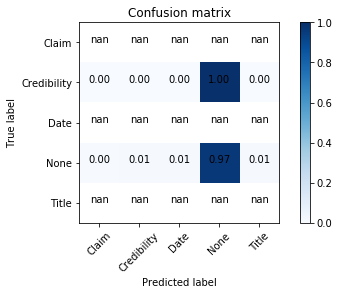

Acc: 96.08 %
Precision: 19.88 %
Recall: 19.33 %
F1: 19.60 %

Acc 90.34 % (+/- 6.29 %)
Precision 22.63 % (+/- 5.62 %)
Recall 21.21 % (+/- 5.49 %)
F1 21.35 % (+/- 5.16 %)


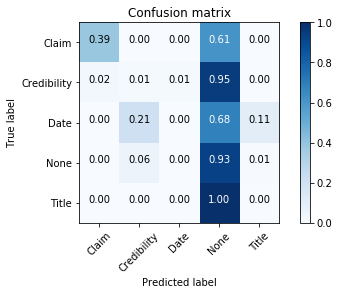

Wall time: 1min 26s


In [22]:
%%time
run_test(['parent_words_context'])

### Parent WordEmbedding

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


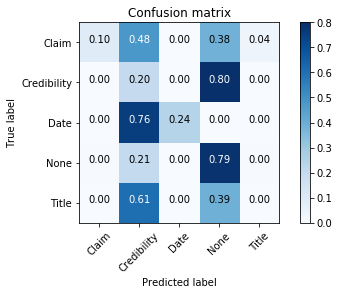

Acc: 77.32 %
Precision: 42.25 %
Recall: 26.51 %
F1: 27.54 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


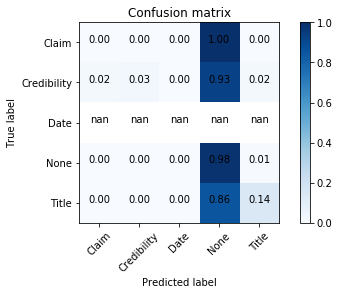

Acc: 93.51 %
Precision: 25.50 %
Recall: 23.06 %
F1: 21.76 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


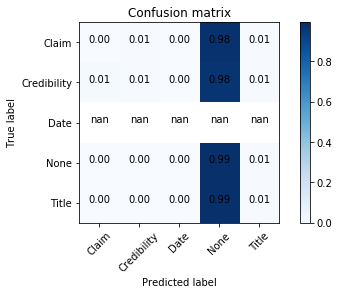

Acc: 89.45 %
Precision: 21.44 %
Recall: 20.05 %
F1: 19.47 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


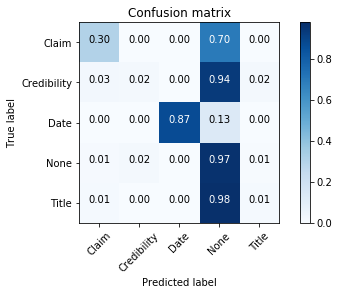

Acc: 88.62 %
Precision: 45.51 %
Recall: 43.39 %
F1: 43.90 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


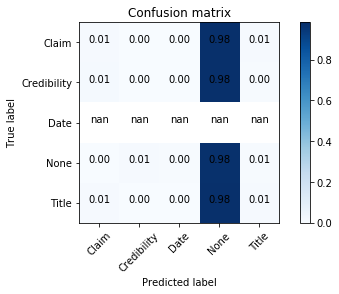

Acc: 83.90 %
Precision: 20.13 %
Recall: 19.91 %
F1: 18.88 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


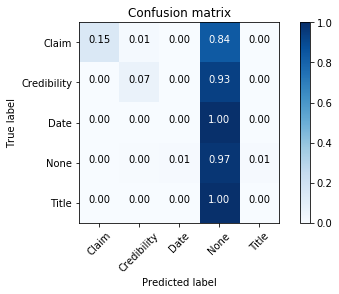

Acc: 94.53 %
Precision: 32.41 %
Recall: 23.71 %
F1: 25.80 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


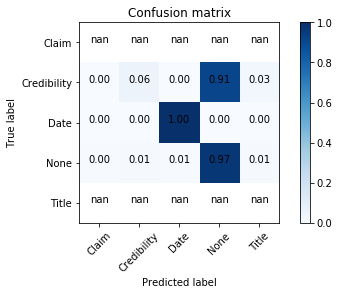

Acc: 95.45 %
Precision: 26.99 %
Recall: 40.54 %
F1: 29.34 %

Acc 88.97 % (+/- 6.04 %)
Precision 30.60 % (+/- 9.21 %)
Recall 28.17 % (+/- 9.00 %)
F1 26.67 % (+/- 7.95 %)


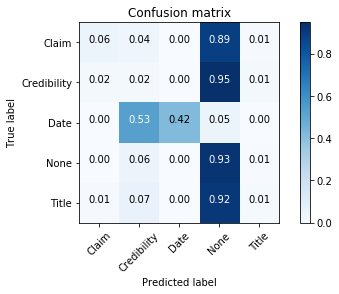

Wall time: 12min 17s


In [23]:
%%time
run_test(['parent_wordEmbedding'])

### Selected features

Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


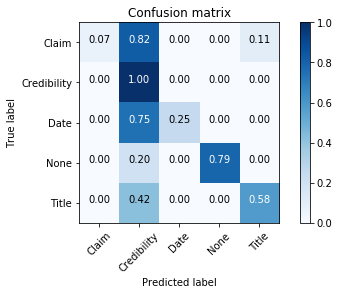

Acc: 78.21 %
Precision: 54.85 %
Recall: 53.85 %
F1: 39.11 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


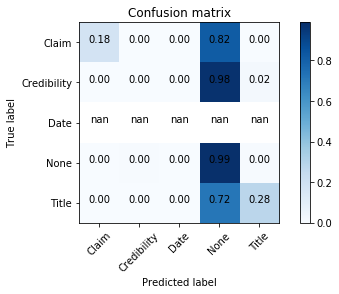

Acc: 94.03 %
Precision: 36.04 %
Recall: 28.94 %
F1: 31.01 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


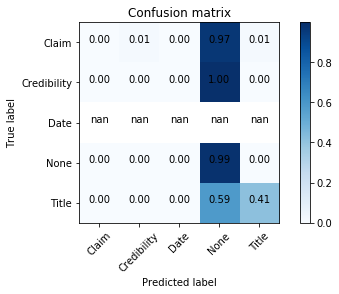

Acc: 91.16 %
Precision: 32.08 %
Recall: 28.07 %
F1: 29.39 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


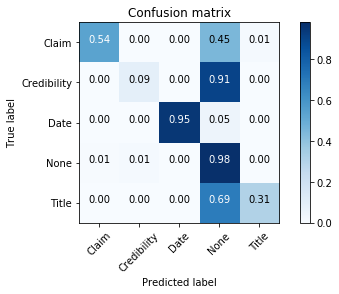

Acc: 91.72 %
Precision: 69.86 %
Recall: 57.39 %
F1: 60.89 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


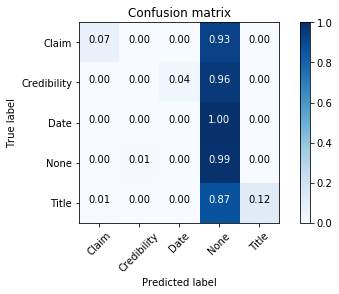

Acc: 81.75 %
Precision: 41.06 %
Recall: 23.57 %
F1: 24.58 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


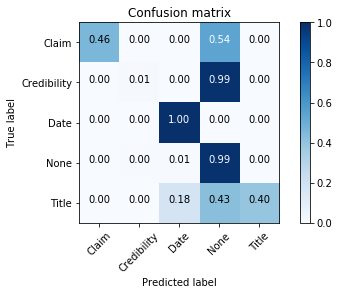

Acc: 86.36 %
Precision: 58.98 %
Recall: 57.07 %
F1: 43.16 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


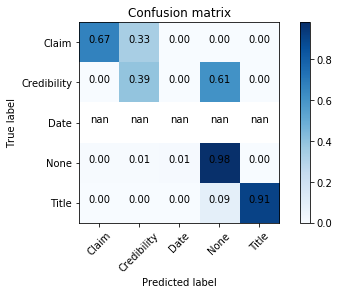

Acc: 97.47 %
Precision: 46.52 %
Recall: 58.92 %
F1: 48.08 %

Acc 88.67 % (+/- 6.37 %)
Precision 48.48 % (+/- 12.48 %)
Recall 43.97 % (+/- 14.96 %)
F1 39.46 % (+/- 11.60 %)


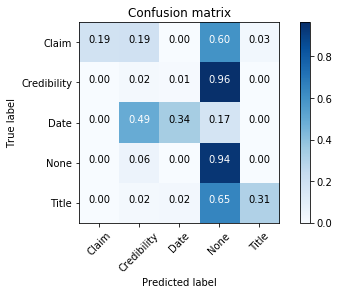

Wall time: 12min 40s


In [11]:
%%time
run_test(['tag', 'words_context', 'wordEmbedding', 'brother_words_context', 'brother_wordEmbedding', 'parent_tag', 'parent_words_context', 'parent_wordEmbedding'])

### Box plot for numeric features

In [14]:
dic_ = {}
for x, y in zip(my_X, my_y):
    if y not in dic_:
        dic_[y] = []
    dic_[y].append(x)

In [16]:
from scipy import stats

In [54]:
data = [[i['text_size'][0] for i in dic_[label] if i['text_size'][0] > 2] for label in dic_]
stats.shapiro(np.array(data[0]))

(0.7092562913894653, 0.0)

In [42]:
stats.shapiro()

(0.7092562913894653, 0.0)

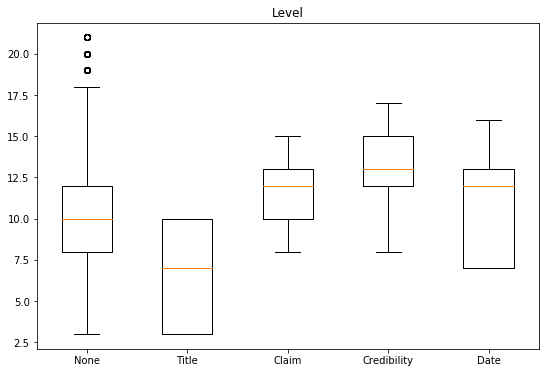

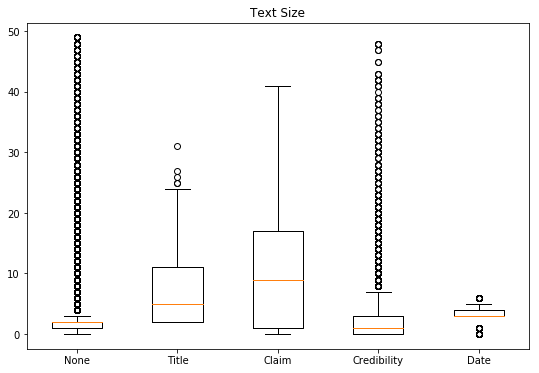

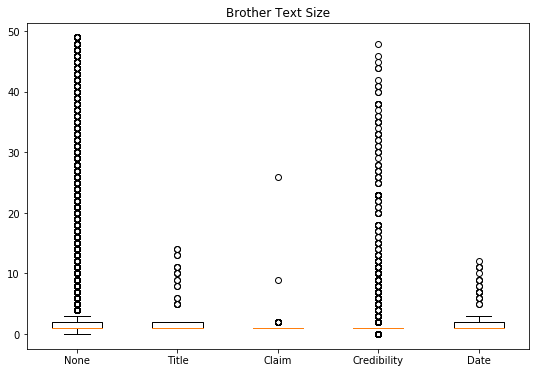

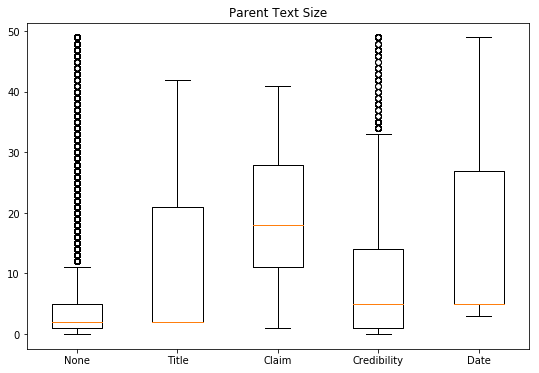

In [74]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt 


def plot_box(title, data):
    fig = plt.figure(1, figsize=(9, 6))
    ax = fig.add_subplot(111, title=title)
    bp = ax.boxplot(data)
    ax.set_xticklabels(dic_.keys())
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.show()

    
#'level''text_size''brother_text_size''parent_text_size'

data_plot = [[i['level'] for i in dic_[label]] for label in dic_]
plot_box('Level', data_plot)

data_plot = [[i['text_size'][0] for i in dic_[label] if i['text_size'][0] < 50 ] for label in dic_]
plot_box('Text Size', data_plot)

data_plot = [[i['brother_text_size'][0] for i in dic_[label] if i['brother_text_size'][0] < 50] for label in dic_]
plot_box('Brother Text Size', data_plot)

data_plot = [[i['parent_text_size'][0] for i in dic_[label] if i['parent_text_size'][0] < 50] for label in dic_]
plot_box('Parent Text Size', data_plot)